In [1]:
from __future__ import annotations

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from causalml.inference.tree import UpliftRandomForestClassifier


C:\Users\tsterk\AppData\Local\anaconda3\envs\causalml_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import pandas as pd
import warnings

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore")

In [3]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "Thesis code" and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from Functions.data_utils import (
    plot_incremental_response_rate,
    uplift_by_decile_bin,
    coerce_metrics_to_numeric,
)

In [4]:
import pandas as pd

file_path = r"Data/covariates_modeling_uplift_models_2026-02-28.csv"
df = pd.read_csv(file_path)


In [5]:
df['cameback'].value_counts()

cameback
0    264223
1      3440
Name: count, dtype: int64

In [6]:
treatment_converter = {
    "BNLX_ChurnP_10_test_export.csv": "treatment_1",
    "BNLX_ChurnP_10_controle_export.csv": "control_1", 
    
    "BNLX_ChurnP_25_test_export.csv": "treatment_2",
    "BNLX_ChurnP_25_controle_export.csv": "control_2",

    "BNLX_ChurnP_5eu_test_export.csv": "treatment_3",
    "BNLX_ChurnP_5eu_controle_export.csv": "control_3",

    "BNLX_ChurnP_10eu_test_export.csv": "treatment_4",
    "BNLX_ChurnP_10eu_controle_export.csv": "control_4",
    
    "BNLX_ChurnP_250_test_export.csv": "treatment_5",
    "BNLX_ChurnP_250_controle_export.csv": "control_5",

    "BNLX_ChurnP_500_test_export.csv": "treatment_6",
    "BNLX_ChurnP_500_controle_export.csv": "control_6",    
    
    "BNLX_ChurnP_SKUd_test_export.csv": "treatment_7",
    "BNLX_ChurnP_SKUd_controle_export.csv": "control_7",

    "BNLX_ChurnP_SKUe_test_export.csv": "treatment_8",
    "BNLX_ChurnP_SKUe_controle_export.csv": "control_8",    
    
    "BNLX_ChurnP_niks_test_export.csv": "treatment_9",
    "BNLX_ChurnP_niks_controle_export.csv": "control_9",
}

df["treatment"] = df["treatment_indicator"].map(treatment_converter)

df['treatment'].unique()


<StringArray>
[  'control_4', 'treatment_7', 'treatment_8', 'treatment_9',   'control_1',
   'control_5',   'control_3',   'control_6', 'treatment_2', 'treatment_6',
   'control_7', 'treatment_4', 'treatment_1',   'control_2',   'control_9',
 'treatment_5', 'treatment_3',   'control_8']
Length: 18, dtype: str

In [7]:
df.head()

,customer_nk,has_rfl,gender,country_sk,treatment_indicator,recency,frequency,monetary_value,total_volume,length_of_relationship,...,volume_52wk,online_sales_52w,retail_sales_52w,frequency_53w_104w,monetary_value_53w_104w,volume_53w_104w,online_sales_53w_104w,retail_sales_53w_104w,cameback,treatment
0,bb9f8a64-a74e-46b0-a094-8d5f7d4878af,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_controle_export.csv,609,5,65.73,10,"1,650",...,2,0.0,5.49,2,12.72,5,0.0,12.72,0,control_4
1,a8004449-d070-4ec1-8d64-b6876880afa5,1,F,hbi|eu|nl,BNLX_ChurnP_SKUd_test_export.csv,799,4,401.31,26,"1,036",...,0,0.0,0,4,401.31,26,337.1,64.21,0,treatment_7
2,03085201-5a63-439c-8a89-82036e06279d,1,F,hbi|eu|nl,BNLX_ChurnP_SKUe_test_export.csv,432,6,220,44,"1,297",...,10,66.14,0,1,21.71,9,21.71,0,0,treatment_8
3,b0768be0-0d30-4193-9c58-006caa04554f,1,F,hbi|eu|nl,BNLX_ChurnP_niks_test_export.csv,477,19,345.85,35,"1,512",...,3,40.34,0,4,48.54,5,23.83,24.71,1,treatment_9
4,a0725963-37b4-4169-8680-04ca27b7086e,1,F,hbi|eu|nl,BNLX_ChurnP_10_controle_export.csv,912,3,55.65,10,"1,759",...,0,0.0,0,1,21.06,4,0.0,21.06,0,control_1


In [8]:
categorical_cols  = ['has_rfl','gender','country_sk']
numeric_cols = [ 'recency', 'frequency', 'monetary_value',  'total_volume', 'length_of_relationship', 'online_sales', 'retail_sales', 
      'food_total', 'vhms_total', 'sports_total', 'beauty_total', 'frequency_52wk', 'monetary_value_52wk', 'volume_52wk', 'online_sales_52w', 
       'retail_sales_52w', 'frequency_53w_104w', 'monetary_value_53w_104w', 'volume_53w_104w', 'online_sales_53w_104w','retail_sales_53w_104w']

In [9]:
df = coerce_metrics_to_numeric(df, numeric_cols)

df[categorical_cols] = df[categorical_cols].astype("object")
df[numeric_cols] = df[numeric_cols].astype("int64")


In [10]:
(100 * df.groupby('treatment_indicator')['cameback'].mean()).round(2)


treatment_indicator
BNLX_ChurnP_10_controle_export.csv      1.13
BNLX_ChurnP_10_test_export.csv          1.29
BNLX_ChurnP_10eu_controle_export.csv    1.28
BNLX_ChurnP_10eu_test_export.csv        1.49
BNLX_ChurnP_250_controle_export.csv     1.17
BNLX_ChurnP_250_test_export.csv         1.51
BNLX_ChurnP_25_controle_export.csv      1.16
BNLX_ChurnP_25_test_export.csv          1.28
BNLX_ChurnP_500_controle_export.csv     1.35
BNLX_ChurnP_500_test_export.csv         1.58
BNLX_ChurnP_5eu_controle_export.csv     1.11
BNLX_ChurnP_5eu_test_export.csv         1.42
BNLX_ChurnP_SKUd_controle_export.csv    1.19
BNLX_ChurnP_SKUd_test_export.csv        1.19
BNLX_ChurnP_SKUe_controle_export.csv    1.20
BNLX_ChurnP_SKUe_test_export.csv        1.27
BNLX_ChurnP_niks_controle_export.csv    1.23
BNLX_ChurnP_niks_test_export.csv        1.28
Name: cameback, dtype: float64

In [11]:
X = df[numeric_cols + categorical_cols]
y = df['cameback']
t = df['treatment']

In [12]:
def five_fold_RF_uplift(
    df: pd.DataFrame,
    X: pd.DataFrame,
    y,
    t,
    *,
    n_splits: int = 5,
    random_state: int = 42,
    control_name: str = "control_0",
) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y_s = pd.Series(y, index=X.index)
    t_s = pd.Series(t, index=X.index)

    fold_results: list[pd.DataFrame] = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, t_s), start=1):
        X_train = X.iloc[train_idx].copy()
        X_test = X.iloc[test_idx].copy()

        y_train = y_s.iloc[train_idx]
        t_train = t_s.iloc[train_idx]

        categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
        numeric_cols = X_train.columns.difference(categorical_cols)

        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

        def _prep_cat(X_part: pd.DataFrame) -> pd.DataFrame:
            if len(categorical_cols) == 0:
                return X_part
            return X_part.assign(
                **{c: X_part[c].astype("string").fillna("MISSING") for c in categorical_cols}
            )

        def encode_X(X_part: pd.DataFrame) -> np.ndarray:
            X_part = _prep_cat(X_part)
            X_num = X_part[numeric_cols].to_numpy()

            if len(categorical_cols) == 0:
                return X_num

            X_cat = ohe.transform(X_part[categorical_cols])
            return np.hstack([X_num, X_cat])


        X_train_prep = _prep_cat(X_train)
        ohe.fit(X_train_prep[categorical_cols])

        X_train_enc = encode_X(X_train)
        X_test_enc = encode_X(X_test)

        uplift_model = UpliftRandomForestClassifier(control_name=control_name, n_estimators= 10, random_state=42)
        uplift_model.fit(
            X_train_enc,
            treatment=t_train.astype(str).values,
            y=y_train.astype(int).values,
        )

        uplift_pred = np.asarray(uplift_model.predict(X_test_enc))
        if uplift_pred.ndim == 1:
            cate = uplift_pred
        else:
            cate = uplift_pred.max(axis=1)

        test_df = df.loc[X_test.index].copy()
        test_df["cate"] = cate
        test_df["fold"] = fold
        fold_results.append(test_df)

    return (
        pd.concat(fold_results, axis=0)
          .sort_values("cate", ascending=False)
    )




In [13]:
cv_test_df = pd.concat(
    [
        five_fold_RF_uplift(
            df=df.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            X=X.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            y=y.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            t=t.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            control_name=f"control_{k}",
        ).assign(experiment_k=k)
        for k in range(1, 10)
        if t.isin([f"treatment_{k}", f"control_{k}"]).any()
    ],
    axis=0,
).sort_values(["experiment_k", "cate"], ascending=[True, False])


In [14]:
cv_test_df[cv_test_df['treatment_indicator']=='BNLX_ChurnP_niks_controle_export.csv'].shape

(14290, 31)

In [15]:
cv_test_df[cv_test_df['treatment'].isin(['treatment_4','control_4'])]['cate'].value_counts()

cate
 0.000658    1483
-0.000302     827
 0.000945     668
 0.001309     566
 0.001937     535
             ... 
-0.073225       1
-0.076331       1
-0.082541       1
-0.084383       1
-0.087613       1
Name: count, Length: 8071, dtype: int64

In [16]:
cv_test_df.groupby('experiment_k')

In [17]:
qini_bins = (
    cv_test_df
    .groupby("experiment_k", group_keys=False)
    .apply(lambda d: uplift_by_decile_bin(d, size=10).assign(incentive_k=d.name))
    .reset_index(drop=True)
)

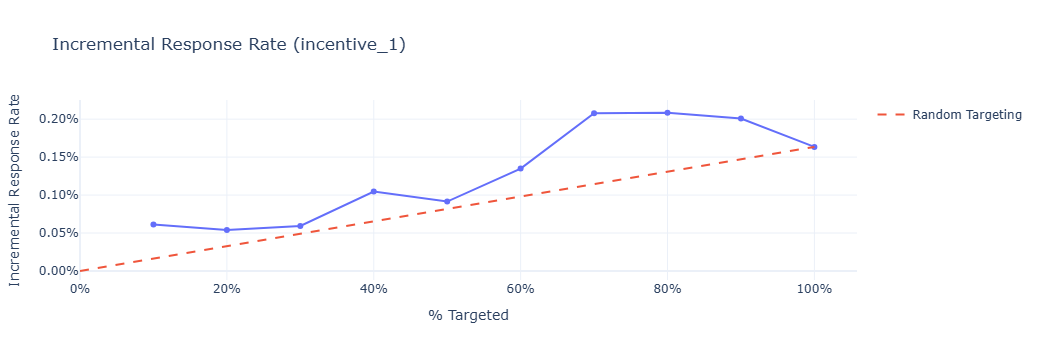

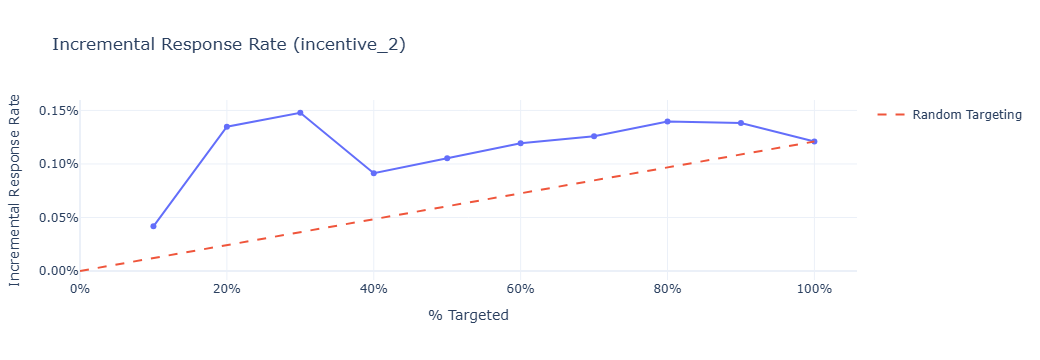

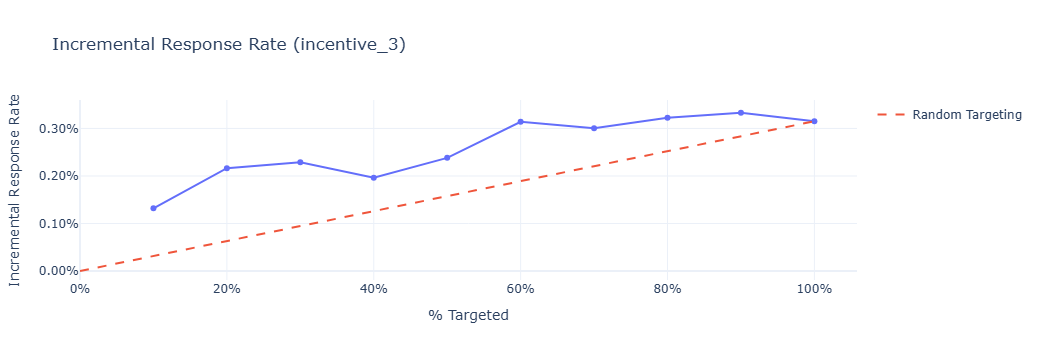

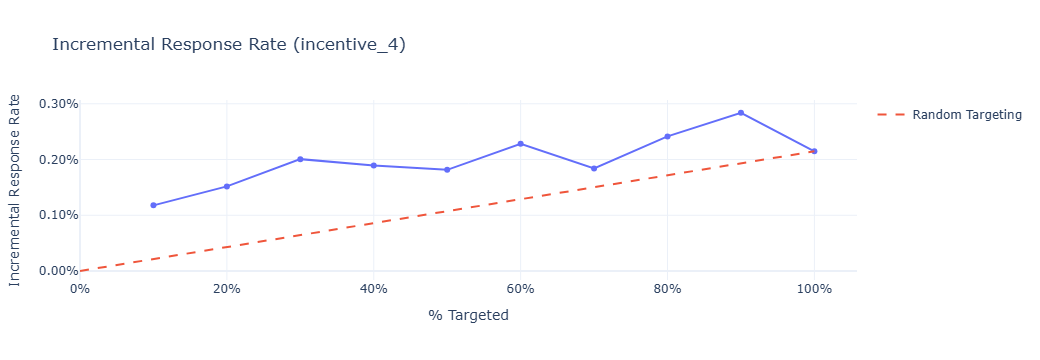

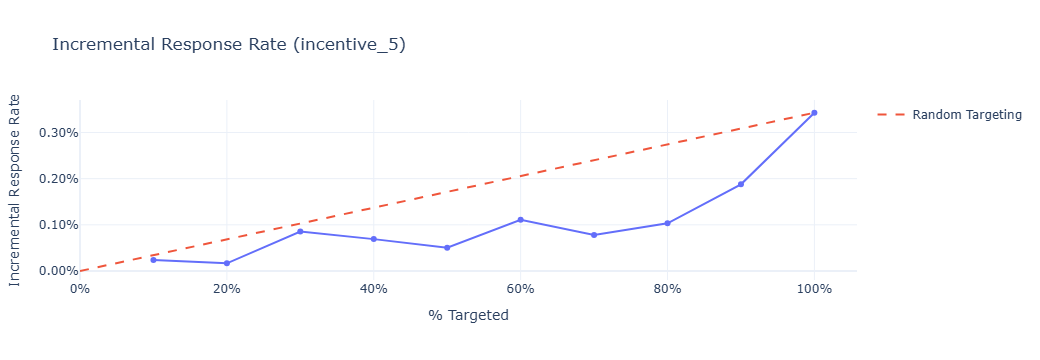

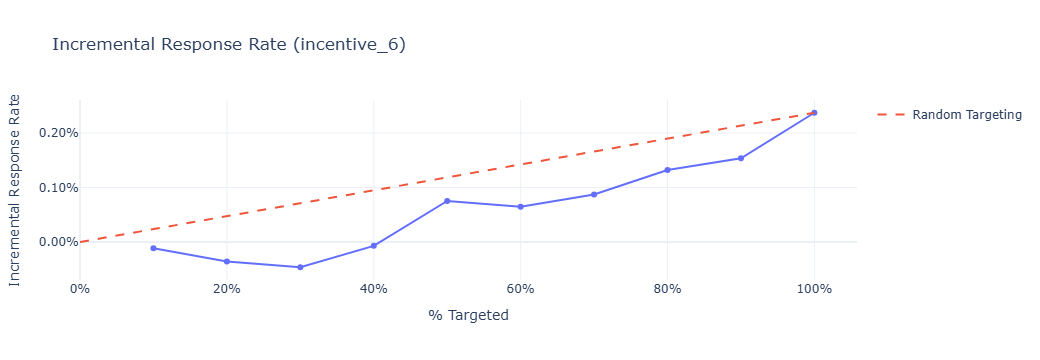

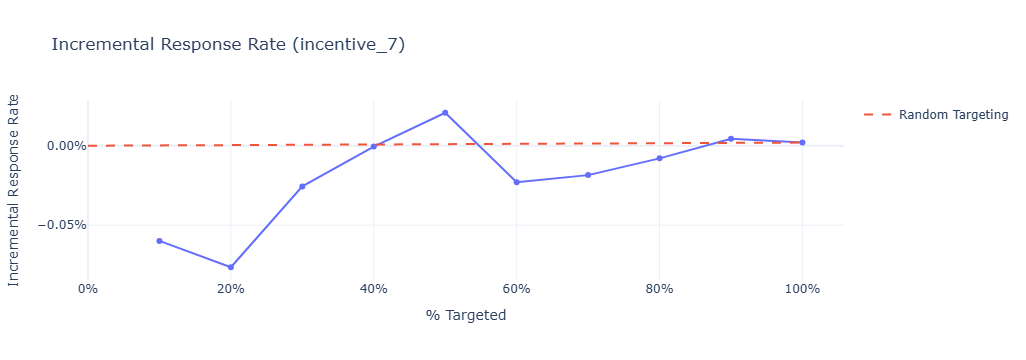

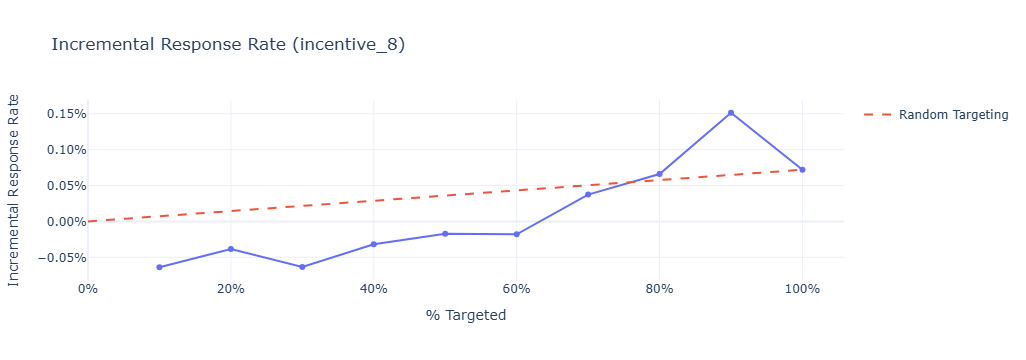

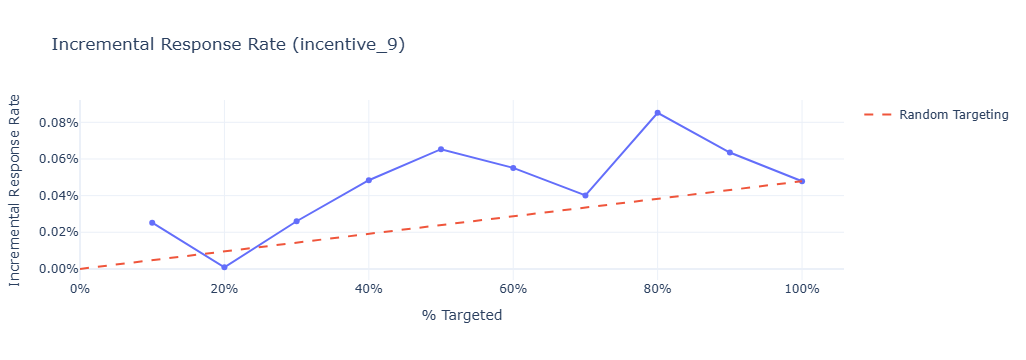

In [27]:
import plotly.io as pio
pio.renderers.default = "jupyterlab"
out_dir = Path("Output")
out_dir.mkdir(parents=True, exist_ok=True)

for k, qini_k in qini_bins.groupby("incentive_k", sort=True):
    fig = plot_incremental_response_rate(qini_k)

    incentive = f"incentive_{k}"

    # Add incentive number to the title
    fig.update_layout(
        title=f"Incremental Response Rate ({incentive})"
    )

    fig.write_html(out_dir / f"{incentive}_incremental_response_rate.html")

    fig.show()


## Covariates analysis

In [31]:
subset.head()monetmo

,customer_nk,has_rfl,gender,country_sk,treatment_indicator,recency,frequency,monetary_value,total_volume,length_of_relationship,...,monetary_value_53w_104w,volume_53w_104w,online_sales_53w_104w,retail_sales_53w_104w,cameback,treatment,cate,fold,experiment_k,monetary_bin
9169,8a90d630-be6c-4b29-841f-f76b004a91e5,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_test_export.csv,411,10,145,19,1833,...,15,6,0,15,0,treatment_4,0.066935,1,4,"(98.0, 162.0]"
55276,1dc12515-97d3-4aa3-9661-d59a85aea798,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_controle_export.csv,602,16,200,25,1813,...,10,2,0,10,0,control_4,0.061014,1,4,"(162.0, 15003.0]"
65470,8b5ea438-7b22-4054-803f-6bcc0916af94,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_test_export.csv,545,11,211,35,1813,...,0,0,0,0,0,treatment_4,0.058927,1,4,"(162.0, 15003.0]"
59615,ad563ade-569d-4f7a-849e-291a6e6767d0,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_test_export.csv,1019,8,212,27,1825,...,43,3,0,43,0,treatment_4,0.058219,1,4,"(162.0, 15003.0]"
105635,cbc7ac45-8553-4e19-8b85-167cb934616e,1,NaN,hbi|eu|be,BNLX_ChurnP_10eu_controle_export.csv,479,9,185,16,1834,...,57,4,0,57,0,control_4,0.052347,1,4,"(162.0, 15003.0]"


In [26]:
subset = cv_test_df.loc[(cv_test_df["experiment_k"] == 4) ].copy()

subset["monetary_bin"] = pd.qcut(
    subset["monetary_value"],
    q=10,
    duplicates="drop"
)

uplift_eval = (
    subset
    .groupby(["monetary_bin", "treatment"])["cameback"]
    .mean()
    .unstack()
)

uplift_eval


treatment,control_4,treatment_4
monetary_bin,,
"(-36.001, 9.0]",0.005731,0.006849
"(9.0, 15.0]",0.009009,0.005867
"(15.0, 20.0]",0.009123,0.012167
"(20.0, 27.0]",0.008712,0.007687
"(27.0, 36.0]",0.009852,0.009804
"(36.0, 49.0]",0.012110,0.016108
"(49.0, 67.0]",0.017532,0.015395
"(67.0, 98.0]",0.014935,0.023889
"(98.0, 162.0]",0.020619,0.023145


In [20]:
""" CATE EXPLORER · Uplift Model Dashboard + Segment Insights
=============================================================
Usage:
    %run cate_explorer_widget.py
    run_cate_explorer(cv_test_df)
    run_cate_explorer(cv_test_df, renderer="iframe")   # JupyterLab inline
    run_cate_explorer(cv_test_df, renderer="browser")  # new browser tab

Segment insights (auto-runs after the dashboard):
    insights  = compute_segment_insights(cv_test_df, experiment_labels=exp_labels)
    print_segment_insights(insights)
    summaries = format_slide_summaries(insights)
"""

import json
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Optional

NUMERIC_COLS = [
    "recency", "frequency", "monetary_value", "total_volume",
    "length_of_relationship", "online_sales", "retail_sales",
    "food_total", "vhms_total", "sports_total", "beauty_total",
    "frequency_52wk", "monetary_value_52wk", "volume_52wk",
    "online_sales_52w", "retail_sales_52w",
    "frequency_53w_104w", "monetary_value_53w_104w", "volume_53w_104w",
    "online_sales_53w_104w", "retail_sales_53w_104w",
]
CATEGORICAL_COLS = ["has_rfl", "gender", "country_sk"]
N_BINS = 10

# ── Palette ───────────────────────────────────────────────────────────────────
BG       = "#0f1117"
SURFACE  = "#181c28"
SURFACE2 = "#1e2235"
BORDER   = "#2c3050"
GRID     = "#1a1e30"
TEXT     = "#e8edf8"
MUTED    = "#5a6180"
C_CTRL   = "#4682B4"
C_TRTM   = "#2d7d46"
C_CATE   = "#b0b8c8"
C_POS    = "#3ecf8e"
C_NEG    = "#f16c6c"
FONT     = "Inter, -apple-system, Arial, sans-serif"

# ── Helpers ───────────────────────────────────────────────────────────────────
def _group(s):
    return s.apply(lambda x: "Treatment" if str(x).startswith("treatment") else "Control")

def pretty(col):
    return col.replace("_", " ").title()

def compute_table(df, col, is_cat):
    needed = ["treatment", "cameback", col] + (["cate"] if "cate" in df.columns else [])
    data = df[needed].copy().dropna(subset=[col, "cameback"])
    data["group"] = _group(data["treatment"])
    has_cate = "cate" in data.columns

    if is_cat:
        data["bin"] = data[col].astype(str)
        bin_order = sorted(data["bin"].unique())
    else:
        try:
            data["bin_idx"] = pd.qcut(data[col], q=N_BINS, labels=False, duplicates="drop")
        except Exception:
            return None
        medians = data.groupby("bin_idx")[col].median().round(0).astype(int).astype(str)
        data["bin"] = data["bin_idx"].map(medians)
        bin_order = medians.tolist()

    agg = (
        data.groupby(["bin", "group"])["cameback"]
        .agg(["sum", "count"])
        .rename(columns={"sum": "cb", "count": "n"})
        .reset_index()
    )
    agg["rr"] = agg["cb"] / agg["n"]

    piv = agg.pivot(index="bin", columns="group", values="rr").reset_index()
    piv.columns.name = None
    cnt = agg.pivot(index="bin", columns="group", values="n").reset_index()
    cnt.columns.name = None

    for g in ["Control", "Treatment"]:
        if g not in piv.columns: piv[g] = np.nan
        if g not in cnt.columns: cnt[g] = 0

    piv["uplift"]  = piv["Treatment"] - piv["Control"]
    piv["ctrl_n"]  = cnt["Control"].values
    piv["trt_n"]   = cnt["Treatment"].values
    piv = piv.rename(columns={"Control": "ctrl_rr", "Treatment": "trt_rr"})
    piv["bin"] = piv["bin"].astype(str)
    piv["avg_cate"] = piv["bin"].map(
        data.groupby("bin")["cate"].mean() if has_cate
        else dict(zip(piv["bin"], piv["uplift"]))
    )

    order_map = {str(b): i for i, b in enumerate(bin_order)}
    piv["_o"] = piv["bin"].map(order_map).fillna(999)
    return piv.sort_values("_o").drop(columns="_o").reset_index(drop=True)


def compute_table_with_ranges(df, col, is_cat):
    """
    Like compute_table but also returns a 'bin_label' column with human-readable
    range descriptions for numeric columns:
        first bin  → "< 123"
        last bin   → "> 456"
        middle bins → "123 – 456"
    Categorical bins keep their original value as the label.
    Also returns a 'bin_range' column with (lo, hi) tuples for numeric cols.
    """
    needed = ["treatment", "cameback", col] + (["cate"] if "cate" in df.columns else [])
    data = df[needed].copy().dropna(subset=[col, "cameback"])
    data["group"] = _group(data["treatment"])
    has_cate = "cate" in data.columns

    if is_cat:
        data["bin"] = data[col].astype(str)
        bin_order = sorted(data["bin"].unique())
        bin_ranges = {}   # not used for categoricals
    else:
        try:
            data["bin_idx"], intervals = pd.qcut(
                data[col], q=N_BINS, labels=False, duplicates="drop", retbins=True
            )
        except Exception:
            return None

        medians = data.groupby("bin_idx")[col].median().round(0).astype(int).astype(str)
        data["bin"] = data["bin_idx"].map(medians)
        bin_order = medians.tolist()

        # Build (lo, hi) per bin_idx using the actual qcut interval edges
        n_intervals = len(intervals) - 1
        bin_ranges = {}
        for idx in range(n_intervals):
            median_key = medians.get(idx)
            if median_key is not None:
                lo = int(round(intervals[idx]))
                hi = int(round(intervals[idx + 1]))
                bin_ranges[median_key] = (lo, hi, idx, n_intervals)

    agg = (
        data.groupby(["bin", "group"])["cameback"]
        .agg(["sum", "count"])
        .rename(columns={"sum": "cb", "count": "n"})
        .reset_index()
    )
    agg["rr"] = agg["cb"] / agg["n"]

    piv = agg.pivot(index="bin", columns="group", values="rr").reset_index()
    piv.columns.name = None
    cnt = agg.pivot(index="bin", columns="group", values="n").reset_index()
    cnt.columns.name = None

    for g in ["Control", "Treatment"]:
        if g not in piv.columns: piv[g] = np.nan
        if g not in cnt.columns: cnt[g] = 0

    piv["uplift"] = piv["Treatment"] - piv["Control"]
    piv["ctrl_n"] = cnt["Control"].values
    piv["trt_n"]  = cnt["Treatment"].values
    piv = piv.rename(columns={"Control": "ctrl_rr", "Treatment": "trt_rr"})
    piv["bin"] = piv["bin"].astype(str)
    piv["avg_cate"] = piv["bin"].map(
        data.groupby("bin")["cate"].mean() if has_cate
        else dict(zip(piv["bin"], piv["uplift"]))
    )

    order_map = {str(b): i for i, b in enumerate(bin_order)}
    piv["_o"] = piv["bin"].map(order_map).fillna(999)
    piv = piv.sort_values("_o").drop(columns="_o").reset_index(drop=True)

    # ── Attach human-readable range labels ───────────────────────────────────
    def make_label(bin_val):
        if is_cat:
            return str(bin_val)
        info = bin_ranges.get(str(bin_val))
        if info is None:
            return str(bin_val)
        lo, hi, idx, n_total = info
        if idx == 0:
            return f"< {hi:,}"
        elif idx == n_total - 1:
            return f"> {lo:,}"
        else:
            return f"{lo:,} – {hi:,}"

    piv["bin_label"] = piv["bin"].apply(make_label)
    return piv


# ── Experiment label helpers ──────────────────────────────────────────────────
def labels_from_treatment_converter(treatment_converter):
    """
    Derive a {experiment_k: label} dict from your treatment_converter.
    Extracts the part between 'BNLX_ChurnP_' and '_test'/'_controle'.
    e.g. "BNLX_ChurnP_10eu_test_export.csv" -> treatment_4 -> {4: "10eu"}
    """
    import re
    exp_labels = {}
    for filename, trt_val in treatment_converter.items():
        m = re.match(r".*_ChurnP_(.+?)_(test|controle)_", filename)
        if not m:
            continue
        name = m.group(1)
        n = re.search(r"(\d+)$", trt_val)
        if n:
            exp_labels[int(n.group(1))] = name
    return exp_labels


# ── Dashboard ─────────────────────────────────────────────────────────────────
def run_cate_explorer(cv_test_df, renderer="iframe", experiment_labels=None):
    """
    experiment_labels: optional dict mapping experiment_k -> display name
                       e.g. {1: "10%", 2: "25%", 3: "5eu", ...}
                       Build automatically with: labels_from_treatment_converter(treatment_converter)
    """
    df = cv_test_df.copy()
    experiments = sorted(df["experiment_k"].dropna().unique().tolist())
    avail_num = [c for c in NUMERIC_COLS if c in df.columns]
    avail_cat = [c for c in CATEGORICAL_COLS if c in df.columns]
    all_cols   = avail_num + avail_cat
    col_is_cat = {c: False for c in avail_num} | {c: True for c in avail_cat}

    if not all_cols:
        print("No recognised predictor columns found.")
        return

    # ── Build segment options ─────────────────────────────────────────────────
    # Each segment is ("all", None, None) or (label, col_name, value)
    seg_options = [("All customers", None, None)]
    for cat_col in avail_cat:
        if cat_col not in df.columns:
            continue
        for val in sorted(df[cat_col].dropna().unique()):
            label = f"{pretty(cat_col)}: {val}"
            seg_options.append((label, cat_col, val))

    def apply_segment(df_in, seg_col, seg_val):
        if seg_col is None:
            return df_in
        return df_in[df_in[seg_col].astype(str) == str(seg_val)]

    pct = lambda v: f"{v*100:.2f}%" if pd.notna(v) else "—"

    # ── Compute tables for all (experiment, col, segment) combos ─────────────
    tables = {}
    for si, (seg_label, seg_col, seg_val) in enumerate(seg_options):
        df_seg = apply_segment(df, seg_col, seg_val)
        for k in experiments:
            df_k = df_seg[df_seg["experiment_k"] == k]
            if df_k.empty:
                continue
            for col in all_cols:
                tbl = compute_table(df_k, col, col_is_cat[col])
                if tbl is not None and not tbl.empty:
                    tables[(si, k, col)] = tbl

    if not tables:
        print("No data could be computed.")
        return

    TPC = 3  # traces per combo: ctrl bar, trtm bar, uplift bar

    # Only include combos that have data
    combo_order = [
        (si, k, col)
        for si in range(len(seg_options))
        for k in experiments
        for col in all_cols
        if (si, k, col) in tables
    ]
    n_combos = len(combo_order)

    valid_exps = sorted({k for _, k, _ in combo_order})
    valid_cols = list(dict.fromkeys(c for _, _, c in combo_order))

    ei_map  = {k: i for i, k in enumerate(valid_exps)}
    ci_map  = {c: i for i, c in enumerate(valid_cols)}

    # combo_matrix[si][ei][ci] = ti or None
    combo_matrix = [
        [[None]*len(valid_cols) for _ in range(len(valid_exps))]
        for _ in range(len(seg_options))
    ]
    for ti, (si, k, col) in enumerate(combo_order):
        if k in ei_map and col in ci_map:
            combo_matrix[si][ei_map[k]][ci_map[col]] = ti

    # ── Build figure ──────────────────────────────────────────────────────────
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.63, 0.37],
        shared_xaxes=False,
        vertical_spacing=0.11,
        specs=[[{"secondary_y": False}], [{"secondary_y": False}]],
    )

    for i, (si, k, col) in enumerate(combo_order):
        tbl = tables[(si, k, col)]
        x   = tbl["bin"].tolist()
        vis = (i == 0)
        sl  = (i == 0)

        ht_c = [f"<b>{r['bin']}</b><br>Control Reactivation Rate: <b>{pct(r['ctrl_rr'])}</b> n={int(r['ctrl_n']):,}"
                for _, r in tbl.iterrows()]
        ht_t = [f"<b>{r['bin']}</b><br>Treatment Reactivation Rate: <b>{pct(r['trt_rr'])}</b> n={int(r['trt_n']):,}"
                for _, r in tbl.iterrows()]
        ht_u = [f"<b>{r['bin']}</b><br>Uplift: <b>{pct(r['uplift'])}</b><br>Control {pct(r['ctrl_rr'])} → Treatment {pct(r['trt_rr'])}"
                for _, r in tbl.iterrows()]
        diff_colors = [C_POS if (pd.notna(v) and v >= 0) else C_NEG for v in tbl["uplift"]]

        fig.add_trace(go.Bar(
            name="Control", x=x, y=tbl["ctrl_rr"],
            marker=dict(color=C_CTRL, opacity=0.9, line=dict(width=0)),
            visible=vis, legendgroup="ctrl", showlegend=sl,
            hovertemplate="%{customdata}<extra></extra>", customdata=ht_c,
        ), row=1, col=1)

        fig.add_trace(go.Bar(
            name="Treatment", x=x, y=tbl["trt_rr"],
            marker=dict(color=C_TRTM, opacity=0.9, line=dict(width=0)),
            visible=vis, legendgroup="trt", showlegend=sl,
            hovertemplate="%{customdata}<extra></extra>", customdata=ht_t,
        ), row=1, col=1)

        fig.add_trace(go.Bar(
            name="Uplift", x=x, y=tbl["uplift"],
            marker=dict(color=diff_colors, opacity=0.9, line=dict(width=0)),
            visible=vis, showlegend=False,
            hovertemplate="%{customdata}<extra></extra>", customdata=ht_u,
        ), row=2, col=1)

    # ── Layout ────────────────────────────────────────────────────────────────
    fsi, fk, fc = combo_order[0]

    # Resolve human-readable experiment name: use provided labels, else str(k)
    def exp_name(k):
        if experiment_labels and k in experiment_labels:
            return str(experiment_labels[k])
        return str(k)

    def make_title(k, col, seg_label):
        seg_tag = (
            f"<span style='font-size:12px;color:{C_POS}'> · {seg_label}</span>"
            if seg_label != "All customers" else ""
        )
        return (
            f"<b style='font-size:13px;color:{TEXT}'>Experiment </b>"
            f"<b style='font-size:13px;color:{TEXT}'>{exp_name(k)}</b> "
            f"<b style='font-size:22px'>{pretty(col)}</b>"
            f"{seg_tag}"
        )

    fig.update_layout(
        title=dict(text=make_title(fk, fc, seg_options[fsi][0]),
                   font=dict(size=22, color=TEXT, family=FONT),
                   x=0.0, xanchor="left", pad=dict(l=10, t=4)),
        barmode="group", bargap=0.20, bargroupgap=0.05,
        height=580, width=960,
        paper_bgcolor=BG, plot_bgcolor=SURFACE,
        font=dict(family=FONT, color=TEXT, size=12),
        legend=dict(orientation="h", yanchor="bottom", y=1.01,
                    xanchor="right", x=1.0, bgcolor="rgba(0,0,0,0)",
                    borderwidth=0, font=dict(size=13, color=TEXT, family=FONT),
                    itemsizing="constant", traceorder="normal"),
        margin=dict(t=130, b=60, l=80, r=80),
        hoverlabel=dict(bgcolor=SURFACE2, bordercolor=BORDER,
                        font=dict(size=12, color=TEXT, family=FONT)),
    )

    axis_common = dict(showgrid=True, gridcolor=GRID, gridwidth=1, zeroline=False,
                       linecolor=BORDER, tickfont=dict(size=12, color=TEXT, family=FONT),
                       tickcolor=BORDER)
    fig.update_xaxes(row=1, col=1, showgrid=False, linecolor=BORDER,
                     tickfont=dict(size=12, color=TEXT, family=FONT), tickcolor=BORDER)
    fig.update_yaxes(row=1, col=1, tickformat=".1%",
                     title_text="<b>Reactivation Rate</b>",
                     title_font=dict(size=13, color=TEXT, family=FONT), **axis_common)
    fig.update_xaxes(row=2, col=1, showgrid=False, linecolor=BORDER,
                     title_text=f"<b>{pretty(fc)}</b>",
                     title_font=dict(size=13, color=TEXT, family=FONT),
                     tickfont=dict(size=12, color=TEXT, family=FONT), tickcolor=BORDER)
    fig.update_yaxes(row=2, col=1, tickformat=".2%", title_text="<b>Uplift</b>",
                     title_font=dict(size=13, color=TEXT, family=FONT),
                     zerolinecolor=BORDER, zerolinewidth=2, **axis_common)

    # ── All visibility arrays ─────────────────────────────────────────────────
    all_vis = []
    for ti in range(n_combos):
        vis_arr = [i == ti for i in range(n_combos) for _ in range(TPC)]
        all_vis.append(vis_arr)

    # All titles: keyed "si,ei,ci"
    all_titles = {}
    for si, (seg_label, _, _) in enumerate(seg_options):
        for k in valid_exps:
            for col in valid_cols:
                ei = ei_map[k]
                ci = ci_map[col]
                all_titles[f"{si},{ei},{ci}"] = make_title(k, col, seg_label)

    js_data = json.dumps({
        "comboMatrix": combo_matrix,   # [si][ei][ci] -> ti or null
        "allVis":      all_vis,        # [ti] -> bool[]
        "allTitles":   all_titles,     # "si,ei,ci" -> html string
        "expLabels":   [exp_name(k) for k in valid_exps],
        "colLabels":   [pretty(c) for c in valid_cols],
        "segLabels":   [s[0] for s in seg_options],
        "nExp":        len(valid_exps),
        "nCol":        len(valid_cols),
        "nSeg":        len(seg_options),
        "TPC":         TPC,
        "bg":          BG,
        "surface2":    SURFACE2,
        "border":      BORDER,
        "text":        TEXT,
        "muted":       MUTED,
        "cPos":        C_POS,
        "font":        FONT,
    })

    # ── Custom dropdown HTML + JS ─────────────────────────────────────────────
    custom_ui = f"""
<script>
(function() {{
  var D = {js_data};
  var activeEi = 0;
  var activeCi = 0;
  var activeSi = 0;
  var gd = null;

  // ── Core: apply a (si, ei, ci) combo ──────────────────────────────────────
  function applyCombo(si, ei, ci) {{
    if (ei < 0 || ci < 0 || si < 0) return;
    if (ei >= D.nExp || ci >= D.nCol || si >= D.nSeg) return;
    var ti = D.comboMatrix[si][ei][ci];
    if (ti === null || ti === undefined) {{
      // Fallback: try "All customers" (si=0) for same ei/ci
      ti = D.comboMatrix[0][ei][ci];
      if (ti === null || ti === undefined) return;
      si = 0;
    }}

    activeEi = ei;
    activeCi = ci;
    activeSi = si;

    Plotly.restyle(gd, {{visible: D.allVis[ti]}});
    var titleKey = si + "," + ei + "," + ci;
    Plotly.relayout(gd, {{
      "title.text": D.allTitles[titleKey] || "",
      "xaxis2.title.text": "<b>" + D.colLabels[ci] + "</b>"
    }});
    updateDropdownUI();
  }}

  function updateDropdownUI() {{
    var expBtn = document.getElementById("cate-exp-btn");
    var colBtn = document.getElementById("cate-col-btn");
    var segBtn = document.getElementById("cate-seg-btn");
    if (expBtn) expBtn.textContent = "Experiment " + D.expLabels[activeEi] + " \u25BE";
    if (colBtn) colBtn.textContent = D.colLabels[activeCi] + " \u25BE";
    if (segBtn) {{
      var isFiltered = activeSi > 0;
      segBtn.textContent = D.segLabels[activeSi] + " \u25BE";
      segBtn.style.borderColor = isFiltered ? D.cPos : D.border;
      segBtn.style.color       = isFiltered ? D.cPos : D.text;
    }}

    document.querySelectorAll(".cate-exp-item").forEach(function(el, i) {{
      el.style.background = (i === activeEi) ? D.border : "transparent";
      el.style.fontWeight = (i === activeEi) ? "bold" : "normal";
    }});
    document.querySelectorAll(".cate-col-item").forEach(function(el, i) {{
      el.style.background = (i === activeCi) ? D.border : "transparent";
      el.style.fontWeight = (i === activeCi) ? "bold" : "normal";
    }});
    document.querySelectorAll(".cate-seg-item").forEach(function(el, i) {{
      el.style.background = (i === activeSi) ? D.border : "transparent";
      el.style.fontWeight = (i === activeSi) ? "bold" : "normal";
      el.style.color      = (i === 0) ? D.text : D.cPos;
    }});
  }}

  function makeDropdown(btnId, listId, itemClass, labels, onClick, accentColor) {{
    var s = D.surface2; var b = D.border; var t = D.text; var f = D.font;
    var wrapper = document.createElement("div");
    wrapper.style.cssText = "position:relative;display:inline-block;margin-right:8px;";

    var btn = document.createElement("button");
    btn.id = btnId;
    btn.style.cssText = [
      "background:" + s,
      "color:" + t,
      "border:1px solid " + b,
      "padding:6px 14px",
      "font-size:13px",
      "font-family:" + f,
      "cursor:pointer",
      "border-radius:4px",
      "min-width:160px",
      "text-align:left",
      "transition:border-color 0.2s,color 0.2s",
    ].join(";");

    var list = document.createElement("div");
    list.id = listId;
    list.style.cssText = [
      "display:none",
      "position:absolute",
      "top:100%",
      "left:0",
      "z-index:9999",
      "background:" + s,
      "border:1px solid " + b,
      "border-radius:4px",
      "min-width:220px",
      "max-height:400px",
      "overflow-y:auto",
      "box-shadow:0 4px 16px rgba(0,0,0,0.5)",
    ].join(";");

    labels.forEach(function(label, i) {{
      var item = document.createElement("div");
      item.className = itemClass;
      item.textContent = label;
      item.dataset.index = i;

      // Visual separator before first actual segment filter
      if (itemClass === "cate-seg-item" && i === 1) {{
        var sep = document.createElement("div");
        sep.style.cssText = "height:1px;background:" + b + ";margin:4px 8px;";
        list.appendChild(sep);
      }}

      item.style.cssText = [
        "padding:8px 14px",
        "cursor:pointer",
        "color:" + (itemClass === "cate-seg-item" && i > 0 ? (accentColor || t) : t),
        "font-size:13px",
        "font-family:" + f,
      ].join(";");
      item.addEventListener("mouseenter", function() {{
        var idx = parseInt(this.dataset.index);
        var isSelf = itemClass === "cate-exp-item" ? (idx === activeEi)
                   : itemClass === "cate-col-item" ? (idx === activeCi)
                   : (idx === activeSi);
        if (!isSelf) this.style.background = "#2a2f45";
      }});
      item.addEventListener("mouseleave", function() {{
        var idx = parseInt(this.dataset.index);
        var isSelf = itemClass === "cate-exp-item" ? (idx === activeEi)
                   : itemClass === "cate-col-item" ? (idx === activeCi)
                   : (idx === activeSi);
        this.style.background = isSelf ? b : "transparent";
      }});
      item.addEventListener("click", function(e) {{
        e.stopPropagation();
        list.style.display = "none";
        onClick(parseInt(this.dataset.index));
      }});
      list.appendChild(item);
    }});

    btn.addEventListener("click", function(e) {{
      e.stopPropagation();
      document.querySelectorAll(".cate-dropdown-list").forEach(function(el) {{
        if (el !== list) el.style.display = "none";
      }});
      list.style.display = list.style.display === "none" ? "block" : "none";
    }});

    list.classList.add("cate-dropdown-list");
    wrapper.appendChild(btn);
    wrapper.appendChild(list);
    return wrapper;
  }}

  // ── Mount ──────────────────────────────────────────────────────────────────
  function mount() {{
    gd = document.querySelector(".plotly-graph-div");
    if (!gd) {{ setTimeout(mount, 100); return; }}

    var container = gd.parentElement;
    var toolbar = document.createElement("div");
    toolbar.style.cssText = [
      "display:flex",
      "align-items:center",
      "gap:8px",
      "padding:8px 0 4px 0px",
      "font-family:" + D.font,
    ].join(";");

    var expDrop = makeDropdown(
      "cate-exp-btn", "cate-exp-list", "cate-exp-item",
      D.expLabels.map(function(l) {{ return "Experiment " + l; }}),
      function(ei) {{ applyCombo(activeSi, ei, activeCi); }}
    );

    var colDrop = makeDropdown(
      "cate-col-btn", "cate-col-list", "cate-col-item",
      D.colLabels,
      function(ci) {{ applyCombo(activeSi, activeEi, ci); }}
    );

    // Segment filter — accentColor highlights non-"All" selections
    var segDrop = makeDropdown(
      "cate-seg-btn", "cate-seg-list", "cate-seg-item",
      D.segLabels,
      function(si) {{ applyCombo(si, activeEi, activeCi); }},
      D.cPos
    );

    // Add a small label before the segment dropdown
    var segLabel = document.createElement("span");
    segLabel.textContent = "Segment:";
    segLabel.style.cssText = [
      "color:" + D.muted,
      "font-size:12px",
      "font-family:" + D.font,
      "margin-left:12px",
      "margin-right:2px",
    ].join(";");

    toolbar.appendChild(expDrop);
    toolbar.appendChild(colDrop);
    toolbar.appendChild(segLabel);
    toolbar.appendChild(segDrop);
    container.insertBefore(toolbar, gd);

    document.addEventListener("click", function() {{
      document.querySelectorAll(".cate-dropdown-list").forEach(function(el) {{
        el.style.display = "none";
      }});
    }});

    updateDropdownUI();
  }}

  if (document.readyState === "loading") {{
    document.addEventListener("DOMContentLoaded", mount);
  }} else {{
    setTimeout(mount, 200);
  }}
}})();
</script>
"""

    # ── Render ────────────────────────────────────────────────────────────────
    html_str = fig.to_html(full_html=True, include_plotlyjs="cdn")
    html_str = html_str.replace("</body>", custom_ui + "\n</body>")

    if renderer == "browser":
        import tempfile, webbrowser
        tmp = tempfile.NamedTemporaryFile(suffix=".html", delete=False, mode="w", encoding="utf-8")
        tmp.write(html_str)
        tmp.close()
        webbrowser.open("file://" + tmp.name)
    else:
        import re
        from IPython.display import display, HTML
        head_scripts = re.findall(r'<script src="[^"]*plotly[^"]*"[^>]*></script>', html_str)
        body_match   = re.search(r"<body[^>]*>(.*)</body>", html_str, re.DOTALL)
        if body_match:
            inline = "\n".join(head_scripts) + "\n" + body_match.group(1)
        else:
            inline = html_str
        display(HTML(inline))


# ═══════════════════════════════════════════════════════════════════════════════
# SEGMENT INSIGHTS
# ═══════════════════════════════════════════════════════════════════════════════

def _score(uplift: float, n_trt: int, n_ctrl: int,
           min_trt: int = 30, min_ctrl: int = 30) -> float:
    """
    Penalised uplift score.

    score = uplift × size_weight × confidence_weight

    size_weight:       smooth sigmoid — tiny segments score near-zero
    confidence_weight: penalises high variance (small n)
    """
    if n_trt < min_trt or n_ctrl < min_ctrl:
        return -np.inf

    n_total = n_trt + n_ctrl

    # logistic curve: ~0.5 at 200 combined customers, approaches 1.0 above ~500
    size_w = 1 / (1 + math.exp(-0.01 * (n_total - 200)))

    # binomial SE at ~2.5% base rate; dampens score when n is small
    se = math.sqrt(0.025 * 0.975 / max(n_trt, 1))
    conf_w = 1 / (1 + 5 * se)

    return float(uplift) * size_w * conf_w


def compute_segment_insights(
    cv_test_df: pd.DataFrame,
    experiment_labels: Optional[dict] = None,
    top_n: int = 5,
    min_trt: int = 30,
    min_ctrl: int = 30,
) -> dict:
    """
    For each experiment, surface the top-N and bottom-N performing bins
    across all predictor columns, normalised for customer volume.

    Parameters
    ----------
    cv_test_df        : your full cross-validation test dataframe
    experiment_labels : optional {experiment_k: display_name} dict
    top_n             : how many best/worst segments to surface per experiment
    min_trt / min_ctrl: hard minimum customers per group — below this a bin is
                        ignored entirely (avoids noise from near-empty cells)

    Returns
    -------
    dict keyed by experiment display-name, each value:
        'best'  : list of dicts (top positive-uplift bins, volume-normalised)
        'worst' : list of dicts (top negative-uplift bins, volume-normalised)
        'meta'  : overall experiment stats
    """
    df = cv_test_df.copy()
    experiments = sorted(df["experiment_k"].dropna().unique().tolist())

    avail_num  = [c for c in NUMERIC_COLS  if c in df.columns]
    avail_cat  = [c for c in CATEGORICAL_COLS if c in df.columns]
    all_cols   = avail_num + avail_cat
    col_is_cat = {c: False for c in avail_num} | {c: True for c in avail_cat}

    def exp_name(k):
        if experiment_labels and k in experiment_labels:
            return str(experiment_labels[k])
        return str(k)

    results = {}

    for k in experiments:
        df_k = df[df["experiment_k"] == k]
        if df_k.empty:
            continue

        name = exp_name(k)
        rows = []

        for col in all_cols:
            tbl = compute_table_with_ranges(df_k, col, col_is_cat[col])
            if tbl is None or tbl.empty:
                continue

            for _, row in tbl.iterrows():
                n_trt  = int(row.get("trt_n",  0))
                n_ctrl = int(row.get("ctrl_n", 0))
                uplift = row.get("uplift", np.nan)

                if pd.isna(uplift):
                    continue

                sc = _score(uplift, n_trt, n_ctrl, min_trt, min_ctrl)
                if sc == -np.inf:
                    continue

                rows.append({
                    "column":       col,
                    "column_label": pretty(col),
                    "bin":          str(row["bin"]),
                    "bin_label":    str(row.get("bin_label", row["bin"])),
                    "ctrl_rr":      row.get("ctrl_rr", np.nan),
                    "trt_rr":       row.get("trt_rr",  np.nan),
                    "uplift":       uplift,
                    "n_trt":        n_trt,
                    "n_ctrl":       n_ctrl,
                    "score":        sc,
                })

        if not rows:
            continue

        scored = pd.DataFrame(rows).sort_values("score", ascending=False)

        # One best and one worst bin per column — prevents a single variable
        # flooding all top-N slots with adjacent bins
        best_per_col  = scored.groupby("column").first().reset_index()
        worst_per_col = (
            scored.sort_values("score", ascending=True)
            .groupby("column").first().reset_index()
        )

        best  = best_per_col.sort_values("score", ascending=False).head(top_n)
        worst = (
            worst_per_col[worst_per_col["uplift"] < 0]
            .sort_values("score", ascending=True)
            .head(top_n)
        )

        # Overall experiment meta
        grp = df_k.groupby(
            df_k["treatment"].apply(
                lambda x: "Treatment" if str(x).startswith("treatment") else "Control"
            )
        )["cameback"].agg(["mean", "count"])

        meta = {
            "n_total": len(df_k),
            "ctrl_rr": grp.loc["Control",   "mean"]  if "Control"   in grp.index else np.nan,
            "trt_rr":  grp.loc["Treatment", "mean"]  if "Treatment" in grp.index else np.nan,
            "n_ctrl":  int(grp.loc["Control",   "count"]) if "Control"   in grp.index else 0,
            "n_trt":   int(grp.loc["Treatment", "count"]) if "Treatment" in grp.index else 0,
        }
        meta["avg_uplift"] = meta["trt_rr"] - meta["ctrl_rr"]

        results[name] = {
            "best":  best.to_dict("records"),
            "worst": worst.to_dict("records"),
            "meta":  meta,
        }

    return results


# ── Formatting helpers ────────────────────────────────────────────────────────

def _fmt_pct(v, sign=False):
    if pd.isna(v):
        return "—"
    return f"{v*100:+.2f}%" if sign else f"{v*100:.2f}%"


def print_segment_insights(insights: dict):
    """Prints a clean console table of top/bottom segments per experiment."""
    for name, data in insights.items():
        meta = data["meta"]
        print(f"\n{'═'*66}")
        print(f"  EXPERIMENT: {name}")
        print(f"{'═'*66}")
        print(f"  Overall  │ Control: {_fmt_pct(meta['ctrl_rr'])}  "
              f"Treatment: {_fmt_pct(meta['trt_rr'])}  "
              f"Uplift: {_fmt_pct(meta['avg_uplift'], sign=True)}")
        print(f"  Customers│ Control n={meta['n_ctrl']:,}  Treatment n={meta['n_trt']:,}")

        print(f"\n  ✅ TOP PERFORMING SEGMENTS")
        print(f"  {'Variable':<28} {'Range':<16} {'Ctrl RR':>8} {'Trt RR':>8} {'Uplift':>9} {'n_trt':>8}")
        print(f"  {'─'*28} {'─'*16} {'─'*8} {'─'*8} {'─'*9} {'─'*8}")
        for r in data["best"]:
            label = r.get("bin_label", r["bin"])
            print(f"  {r['column_label']:<28} {label:<16} "
                  f"{_fmt_pct(r['ctrl_rr']):>8} {_fmt_pct(r['trt_rr']):>8} "
                  f"{_fmt_pct(r['uplift'], sign=True):>9} {r['n_trt']:>8,}")

        if data["worst"]:
            print(f"\n  ❌ WORST PERFORMING SEGMENTS")
            print(f"  {'Variable':<28} {'Range':<16} {'Ctrl RR':>8} {'Trt RR':>8} {'Uplift':>9} {'n_trt':>8}")
            print(f"  {'─'*28} {'─'*16} {'─'*8} {'─'*8} {'─'*9} {'─'*8}")
            for r in data["worst"]:
                label = r.get("bin_label", r["bin"])
                print(f"  {r['column_label']:<28} {label:<16} "
                      f"{_fmt_pct(r['ctrl_rr']):>8} {_fmt_pct(r['trt_rr']):>8} "
                      f"{_fmt_pct(r['uplift'], sign=True):>9} {r['n_trt']:>8,}")


def format_slide_summaries(insights: dict) -> dict:
    """
    Returns one slide-ready bullet-point block per experiment.
    Copy directly into PowerPoint notes or a text box.

    Example output:
        Overall uplift: +0.82% (ctrl 2.14% → trt 2.96%)

        Best segments:
          • Monetary Value > 100: uplift +1.84pp  (ctrl 1.90% → trt 3.74%, n_trt=4,210)
          • Recency < 500:        uplift +1.41pp  (ctrl 2.10% → trt 3.51%, n_trt=3,100)
    """
    summaries = {}
    for name, data in insights.items():
        meta  = data["meta"]
        lines = [
            f"Overall uplift: {_fmt_pct(meta['avg_uplift'], sign=True)} "
            f"(ctrl {_fmt_pct(meta['ctrl_rr'])} → trt {_fmt_pct(meta['trt_rr'])})",
            "",
            "Best segments:",
        ]
        for r in data["best"]:
            pp    = r["uplift"] * 100
            label = r.get("bin_label", r["bin"])
            lines.append(
                f"  • {r['column_label']} {label}: "
                f"uplift {pp:+.2f}pp  "
                f"(ctrl {_fmt_pct(r['ctrl_rr'])} → trt {_fmt_pct(r['trt_rr'])}, "
                f"n_trt={r['n_trt']:,})"
            )
        if data["worst"]:
            lines += ["", "Worst segments:"]
            for r in data["worst"]:
                pp    = r["uplift"] * 100
                label = r.get("bin_label", r["bin"])
                lines.append(
                    f"  • {r['column_label']} {label}: "
                    f"uplift {pp:+.2f}pp  "
                    f"(ctrl {_fmt_pct(r['ctrl_rr'])} → trt {_fmt_pct(r['trt_rr'])}, "
                    f"n_trt={r['n_trt']:,})"
                )
        summaries[name] = "\n".join(lines)
    return summaries
# ═══════════════════════════════════════════════════════════════════════════════
# INCENTIVE SELECTOR  —  "which incentive works best for this segment?"
# ═══════════════════════════════════════════════════════════════════════════════
#
# Usage:
#   selector = compute_incentive_selector(cv_test_df, experiment_labels=exp_labels)
#   print_incentive_selector(selector)
#
# For each numeric variable it cuts customers into three tiers:
#   low  (0–33rd pct)  ·  mid (33–66th pct)  ·  high (66–100th pct)
# Then for each tier × each experiment it computes the uplift, and picks the
# single best-performing incentive (volume-normalised, same _score as above).
# ═══════════════════════════════════════════════════════════════════════════════

def _build_tiers(col_data: pd.Series):
    """
    Build four non-overlapping, non-empty tiers for a numeric column.

    Normal distribution  → low (0–33%) / mid (33–66%) / high (66–90%) / top10 (90–100%)
    Zero-inflated        → = 0 / > 0 low half / > 0 high half / top 10% of non-zero
    A column is considered zero-inflated when >25% of values are exactly zero
    AND p66 == 0 (i.e. the standard tertile split degenerates).
    """
    zero_frac = (col_data == 0).mean()
    p66       = col_data.quantile(0.666)

    if zero_frac > 0.25 and p66 == 0:
        nonzero  = col_data[col_data > 0]
        p50_nz   = nonzero.median() if len(nonzero) else 1
        p90_nz   = nonzero.quantile(0.90) if len(nonzero) else 1
        col_max  = col_data.max()
        return [
            ("zero",      0,       0,       lambda s, c: s[c] == 0),
            ("nz_low",    0,       p50_nz,  lambda s, c: (s[c] > 0) & (s[c] <= p50_nz)),
            ("nz_high",   p50_nz,  p90_nz,  lambda s, c: (s[c] > p50_nz) & (s[c] <= p90_nz)),
            ("top10",     p90_nz,  col_max, lambda s, c: s[c] > p90_nz),
        ], True
    else:
        p33     = col_data.quantile(0.333)
        p90     = col_data.quantile(0.90)
        col_min = col_data.min()
        col_max = col_data.max()
        return [
            ("low",   col_min, p33,     lambda s, c: s[c] <= p33),
            ("mid",   p33,     p66,     lambda s, c: (s[c] > p33) & (s[c] <= p66)),
            ("high",  p66,     p90,     lambda s, c: (s[c] > p66) & (s[c] <= p90)),
            ("top10", p90,     col_max, lambda s, c: s[c] > p90),
        ], False


def _tier_label_v2(lo: float, hi: float, tier: str, zero_inflated: bool) -> str:
    lo_i, hi_i = int(round(lo)), int(round(hi))
    if zero_inflated:
        if tier == "zero":    return "= 0"
        if tier == "nz_low":  return f"1 – {hi_i:,}"
        if tier == "nz_high": return f"{lo_i:,} – {hi_i:,}"
        if tier == "top10":   return f"> {lo_i:,}  (top 10%)"
    else:
        if tier == "low":     return f"< {hi_i:,}"
        if tier == "top10":   return f"> {lo_i:,}  (top 10%)"
        if tier == "high":    return f"{lo_i:,} – {hi_i:,}"
        return f"{lo_i:,} – {hi_i:,}"
    return str(lo_i)


def compute_incentive_selector(
    cv_test_df: pd.DataFrame,
    experiment_labels: Optional[dict] = None,
    min_trt: int = 30,
    min_ctrl: int = 30,
) -> dict:
    """
    For each numeric variable × tier, find the best-performing incentive.

    Handles zero-inflated columns (online_sales, retail_sales, category totals)
    by using a zero / non-zero-low / non-zero-high split instead of equal
    tertiles, which previously produced empty 0–0 mid tiers.

    Returns
    -------
    dict keyed by column name, each value a list of 3 dicts:
        tier        : tier identifier string
        tier_label  : human-readable range, e.g. "< 180" / "= 0" / "1 – 42"
        best_exp    : display name of the winning incentive
        uplift      : its uplift (as float, e.g. 0.0047)
        ctrl_rr     : control comeback rate
        trt_rr      : treatment comeback rate
        n_trt       : treated customers in this tier
        n_ctrl      : control customers in this tier
        runner_up   : second-best incentive name (or None)
        all_uplifts : {exp_name: uplift} for all experiments
    """
    df = cv_test_df.copy()
    experiments = sorted(df["experiment_k"].dropna().unique().tolist())
    avail_num   = [c for c in NUMERIC_COLS if c in df.columns]

    def exp_name(k):
        if experiment_labels and k in experiment_labels:
            return str(experiment_labels[k])
        return str(k)

    results = {}

    for col in avail_num:
        col_data = df[col].dropna()
        if col_data.nunique() < 3:
            continue

        tiers_def, zero_inflated = _build_tiers(col_data)
        tier_results = []

        for tier_name, lo, hi, mask_fn in tiers_def:
            mask     = mask_fn(df, col)
            df_tier  = df[mask]
            label    = _tier_label_v2(lo, hi, tier_name, zero_inflated)

            # Compute uplift per experiment for this tier
            exp_rows = []
            all_uplifts = {}

            for k in experiments:
                df_k = df_tier[df_tier["experiment_k"] == k].copy()
                if df_k.empty:
                    continue

                df_k["_grp"] = _group(df_k["treatment"])
                grp = df_k.groupby("_grp")["cameback"].agg(["mean", "count"])

                if "Control" not in grp.index or "Treatment" not in grp.index:
                    continue

                ctrl_rr = grp.loc["Control",   "mean"]
                trt_rr  = grp.loc["Treatment", "mean"]
                n_ctrl  = int(grp.loc["Control",   "count"])
                n_trt   = int(grp.loc["Treatment", "count"])
                uplift  = trt_rr - ctrl_rr

                sc = _score(uplift, n_trt, n_ctrl, min_trt, min_ctrl)
                name = exp_name(k)
                all_uplifts[name] = uplift

                if sc == -np.inf:
                    continue

                exp_rows.append({
                    "exp":     name,
                    "uplift":  uplift,
                    "ctrl_rr": ctrl_rr,
                    "trt_rr":  trt_rr,
                    "n_trt":   n_trt,
                    "n_ctrl":  n_ctrl,
                    "score":   sc,
                })

            if not exp_rows:
                tier_results.append({
                    "tier": tier_name, "tier_label": label,
                    "best_exp": None, "uplift": np.nan,
                    "ctrl_rr": np.nan, "trt_rr": np.nan,
                    "n_trt": 0, "n_ctrl": 0,
                    "runner_up": None, "all_uplifts": all_uplifts,
                })
                continue

            ranked = sorted(exp_rows, key=lambda x: x["score"], reverse=True)
            best   = ranked[0]

            tier_results.append({
                "tier":        tier_name,
                "tier_label":  label,
                "best_exp":    best["exp"],
                "uplift":      best["uplift"],
                "ctrl_rr":     best["ctrl_rr"],
                "trt_rr":      best["trt_rr"],
                "n_trt":       best["n_trt"],
                "n_ctrl":      best["n_ctrl"],
                "runner_up":   ranked[1]["exp"] if len(ranked) > 1 else None,
                "all_uplifts": all_uplifts,
            })

        results[col] = tier_results

    return results


def print_incentive_selector(selector: dict):
    """
    Prints a table: for each variable × tier, which incentive wins and by how much.

    Example:
      MONETARY VALUE
      ─────────────────────────────────────────────────────────────────
      Tier          Range        Best Incentive   Uplift   Ctrl    Trt
      low           < 180        5eu              +0.18%   1.10%  1.28%
      mid           180 – 450    10eu             +0.22%   1.05%  1.27%
      high          > 450        250              +0.41%   1.20%  1.61%
    """
    HDR  = f"  {'Tier':<6} {'Range':<16} {'Best Incentive':<18} {'Uplift':>8} {'Ctrl RR':>8} {'Trt RR':>8} {'n_trt':>8}  {'Runner-up'}"
    SEP  = "  " + "─" * 84

    for col, tiers in selector.items():
        print(f"\n{'═'*88}")
        print(f"  {pretty(col).upper()}")
        print(f"{'═'*88}")
        print(HDR)
        print(SEP)
        for t in tiers:
            best     = t["best_exp"] or "—"
            ru       = t["runner_up"] or ""
            tier_disp = {"low": "low", "mid": "mid", "high": "high", "top10": "top 10%",
                         "zero": "= 0", "nz_low": "> 0 low", "nz_high": "> 0 high",
                        }.get(t["tier"], t["tier"])
            print(
                f"  {tier_disp:<10} {t['tier_label']:<16} {best:<18} "
                f"{_fmt_pct(t['uplift'], sign=True):>8} "
                f"{_fmt_pct(t['ctrl_rr']):>8} "
                f"{_fmt_pct(t['trt_rr']):>8} "
                f"{t['n_trt']:>8,}  {ru}"
            )


def format_incentive_selector_slides(selector: dict) -> dict:
    """
    Returns slide-ready text per variable — one block per variable,
    three bullets (low / mid / high).

    Example:
        Monetary Value
          • Low  (< 180):     → 5eu      uplift +0.18pp  (ctrl 1.10% → trt 1.28%, n=3,100)
          • Mid  (180–450):   → 10eu     uplift +0.22pp  (ctrl 1.05% → trt 1.27%, n=3,400)
          • High (> 450):     → 250      uplift +0.41pp  (ctrl 1.20% → trt 1.61%, n=2,900)
    """
    slides = {}
    tier_display = {
        "low": "Low ", "mid": "Mid ", "high": "High", "top10": "Top 10%",
        "zero": "= 0 ", "nz_low": "> 0 low ", "nz_high": "> 0 high",
    }

    for col, tiers in selector.items():
        lines = [pretty(col)]
        for t in tiers:
            td    = tier_display.get(t["tier"], t["tier"])
            best  = t["best_exp"] or "—"
            pp    = t["uplift"] * 100 if pd.notna(t["uplift"]) else float("nan")
            ru    = f"  (runner-up: {t['runner_up']})" if t["runner_up"] else ""
            lines.append(
                f"  • {td} ({t['tier_label']}):".ljust(24)
                + f" → {best:<12} "
                + (f"uplift {pp:+.2f}pp  "
                   f"(ctrl {_fmt_pct(t['ctrl_rr'])} → trt {_fmt_pct(t['trt_rr'])}, "
                   f"n_trt={t['n_trt']:,}){ru}"
                   if pd.notna(pp) else "insufficient data")
            )
        slides[col] = "\n".join(lines)

    return slides

In [23]:
exp_labels = labels_from_treatment_converter(treatment_converter)
run_cate_explorer(cv_test_df, experiment_labels=exp_labels, renderer="browser")


In [24]:
insights = compute_segment_insights(cv_test_df, experiment_labels=exp_labels)
print_segment_insights(insights)


══════════════════════════════════════════════════════════════════
  EXPERIMENT: 10
══════════════════════════════════════════════════════════════════
  Overall  │ Control: 1.13%  Treatment: 1.29%  Uplift: +0.16%
  Customers│ Control n=15,489  Treatment n=14,769

  ✅ TOP PERFORMING SEGMENTS
  Variable                     Range             Ctrl RR   Trt RR    Uplift    n_trt
  ──────────────────────────── ──────────────── ──────── ──────── ───────── ────────
  Volume 53W 104W              > 7                 2.20%    3.94%    +1.74%    1,397
  Monetary Value               > 164               2.12%    3.55%    +1.43%    1,464
  Monetary Value 52Wk          > 48                2.07%    3.48%    +1.42%    1,464
  Volume 52Wk                  > 6                 2.39%    3.74%    +1.36%    1,469
  Frequency 53W 104W           > 2                 2.25%    3.57%    +1.32%    1,120

  ❌ WORST PERFORMING SEGMENTS
  Variable                     Range             Ctrl RR   Trt RR    Uplift    n_

In [32]:
selector = compute_incentive_selector(cv_test_df, experiment_labels=exp_labels)
print_incentive_selector(selector)



════════════════════════════════════════════════════════════════════════════════════════
  RECENCY
════════════════════════════════════════════════════════════════════════════════════════
  Tier   Range            Best Incentive       Uplift  Ctrl RR   Trt RR    n_trt  Runner-up
  ────────────────────────────────────────────────────────────────────────────────────
  low        < 648            250                  +0.64%    1.69%    2.33%    5,236  10
  mid        648 – 1,128      5eu                  +0.42%    0.96%    1.39%    4,980  10eu
  high       1,128 – 1,496    5eu                  +0.43%    0.51%    0.94%    3,399  10
  top 10%    > 1,496  (top 10%) 250                  +0.62%    0.13%    0.75%    1,457  500

════════════════════════════════════════════════════════════════════════════════════════
  FREQUENCY
════════════════════════════════════════════════════════════════════════════════════════
  Tier   Range            Best Incentive       Uplift  Ctrl RR   Trt RR    n_trt

In [37]:
def _evaluate_best_experiment_for_subset(
    df_subset: pd.DataFrame,
    experiments: list,
    exp_name_fn,
    min_trt: int,
    min_ctrl: int,
) -> dict:
    """
    Evaluate all experiments for a pre-filtered subset and return the winning
    incentive plus supporting metrics.
    """
    exp_rows = []
    all_uplifts = {}

    for k in experiments:
        df_k = df_subset[df_subset["experiment_k"] == k].copy()
        if df_k.empty:
            continue

        df_k["_grp"] = _group(df_k["treatment"])
        grp = df_k.groupby("_grp")["cameback"].agg(["mean", "count"])

        if "Control" not in grp.index or "Treatment" not in grp.index:
            continue

        ctrl_rr = grp.loc["Control", "mean"]
        trt_rr = grp.loc["Treatment", "mean"]
        n_ctrl = int(grp.loc["Control", "count"])
        n_trt = int(grp.loc["Treatment", "count"])
        uplift = trt_rr - ctrl_rr

        exp_label = exp_name_fn(k)
        all_uplifts[exp_label] = uplift

        sc = _score(uplift, n_trt, n_ctrl, min_trt, min_ctrl)
        if sc == -np.inf:
            continue

        exp_rows.append({
            "exp": exp_label,
            "uplift": uplift,
            "ctrl_rr": ctrl_rr,
            "trt_rr": trt_rr,
            "n_trt": n_trt,
            "n_ctrl": n_ctrl,
            "score": sc,
        })

    if not exp_rows:
        return {
            "best_exp": None,
            "uplift": np.nan,
            "ctrl_rr": np.nan,
            "trt_rr": np.nan,
            "n_trt": 0,
            "n_ctrl": 0,
            "runner_up": None,
            "all_uplifts": all_uplifts,
        }

    ranked = sorted(exp_rows, key=lambda x: x["score"], reverse=True)
    best = ranked[0]

    return {
        "best_exp": best["exp"],
        "uplift": best["uplift"],
        "ctrl_rr": best["ctrl_rr"],
        "trt_rr": best["trt_rr"],
        "n_trt": best["n_trt"],
        "n_ctrl": best["n_ctrl"],
        "runner_up": ranked[1]["exp"] if len(ranked) > 1 else None,
        "all_uplifts": all_uplifts,
    }


def compute_incentive_selector(
    cv_test_df: pd.DataFrame,
    experiment_labels: Optional[dict] = None,
    min_trt: int = 30,
    min_ctrl: int = 30,
) -> dict:
    """
    For each variable segment, find the best-performing incentive.

    Numeric variables:
        Uses the existing tier logic (low / mid / high / top10, with special
        handling for zero-inflated columns).

    Categorical variables:
        Uses each observed category value as its own segment
        (for example has_rfl=0, has_rfl=1).

    Returns
    -------
    dict keyed by column name, each value a list of segment dicts:
        segment_type : "numeric" or "categorical"
        segment      : segment name (e.g. "low", "mid", "value")
        segment_label: human-readable range or category value
        best_exp     : winning incentive
        uplift       : winning uplift
        ctrl_rr      : control comeback rate
        trt_rr       : treatment comeback rate
        n_trt        : treated customers in segment
        n_ctrl       : control customers in segment
        runner_up    : second-best incentive
        all_uplifts  : uplift for all experiments in that segment
    """
    df = cv_test_df.copy()
    experiments = sorted(df["experiment_k"].dropna().unique().tolist())

    avail_num = [c for c in NUMERIC_COLS if c in df.columns]
    avail_cat = [c for c in CATEGORICAL_COLS if c in df.columns]

    def exp_name(k):
        if experiment_labels and k in experiment_labels:
            return str(experiment_labels[k])
        return str(k)

    results = {}

    # Numeric variables
    for col in avail_num:
        col_data = df[col].dropna()
        if col_data.nunique() < 3:
            continue

        tiers_def, zero_inflated = _build_tiers(col_data)
        segment_results = []

        for tier_name, lo, hi, mask_fn in tiers_def:
            mask = mask_fn(df, col)
            df_segment = df[mask]
            label = _tier_label_v2(lo, hi, tier_name, zero_inflated)

            ranked = _evaluate_best_experiment_for_subset(
                df_subset=df_segment,
                experiments=experiments,
                exp_name_fn=exp_name,
                min_trt=min_trt,
                min_ctrl=min_ctrl,
            )

            segment_results.append({
                "segment_type": "numeric",
                "segment": tier_name,
                "segment_label": label,
                "tier": tier_name,
                "tier_label": label,
                "best_exp": ranked["best_exp"],
                "uplift": ranked["uplift"],
                "ctrl_rr": ranked["ctrl_rr"],
                "trt_rr": ranked["trt_rr"],
                "n_trt": ranked["n_trt"],
                "n_ctrl": ranked["n_ctrl"],
                "runner_up": ranked["runner_up"],
                "all_uplifts": ranked["all_uplifts"],
            })

        results[col] = segment_results

    # Categorical variables
    for col in avail_cat:
        col_data = df[col].dropna()
        if col_data.empty:
            continue

        category_values = sorted(col_data.astype(str).unique().tolist())
        if not category_values:
            continue

        segment_results = []

        for val in category_values:
            df_segment = df[df[col].astype(str) == val]

            ranked = _evaluate_best_experiment_for_subset(
                df_subset=df_segment,
                experiments=experiments,
                exp_name_fn=exp_name,
                min_trt=min_trt,
                min_ctrl=min_ctrl,
            )

            segment_results.append({
                "segment_type": "categorical",
                "segment": "value",
                "segment_label": str(val),
                "tier": "value",
                "tier_label": str(val),
                "best_exp": ranked["best_exp"],
                "uplift": ranked["uplift"],
                "ctrl_rr": ranked["ctrl_rr"],
                "trt_rr": ranked["trt_rr"],
                "n_trt": ranked["n_trt"],
                "n_ctrl": ranked["n_ctrl"],
                "runner_up": ranked["runner_up"],
                "all_uplifts": ranked["all_uplifts"],
            })

        results[col] = segment_results

    return results


def print_incentive_selector(selector: dict):
    """
    Prints a table: for each variable segment, which incentive wins and by how much.

    Numeric example:
      Monetary Value
      Segment      Value / Range       Best Incentive   Uplift   Ctrl    Trt

    Categorical example:
      Gender
      Segment      Value / Range       Best Incentive   Uplift   Ctrl    Trt
      value        F                   10eu             +0.32%   1.10%  1.42%
      value        M                   5eu              +0.18%   1.04%  1.22%
    """
    segment_display = {
        "low": "low",
        "mid": "mid",
        "high": "high",
        "top10": "top 10%",
        "zero": "= 0",
        "nz_low": "> 0 low",
        "nz_high": "> 0 high",
        "value": "value",
    }

    HDR = (
        f"  {'Segment':<12} {'Value / Range':<18} {'Best Incentive':<18} "
        f"{'Uplift':>8} {'Ctrl RR':>8} {'Trt RR':>8} {'n_trt':>8}  {'Runner-up'}"
    )
    SEP = "  " + "─" * 96

    for col, segments in selector.items():
        print(f"\n{'═'*100}")
        print(f"  {pretty(col).upper()}")
        print(f"{'═'*100}")
        print(HDR)
        print(SEP)

        for s in segments:
            seg_name = s.get("segment", s.get("tier", ""))
            seg_label = s.get("segment_label", s.get("tier_label", ""))
            seg_disp = segment_display.get(seg_name, str(seg_name))

            best = s["best_exp"] or "-"
            runner_up = s["runner_up"] or ""

            print(
                f"  {seg_disp:<12} {str(seg_label):<18} {best:<18} "
                f"{_fmt_pct(s['uplift'], sign=True):>8} "
                f"{_fmt_pct(s['ctrl_rr']):>8} "
                f"{_fmt_pct(s['trt_rr']):>8} "
                f"{s['n_trt']:>8,}  {runner_up}"
            )


def format_incentive_selector_slides(selector: dict) -> dict:
    """
    Returns slide-ready text per variable, now supporting both numeric and
    categorical segments.
    """
    segment_display = {
        "low": "Low",
        "mid": "Mid",
        "high": "High",
        "top10": "Top 10%",
        "zero": "= 0",
        "nz_low": "> 0 low",
        "nz_high": "> 0 high",
        "value": "Value",
    }

    slides = {}

    for col, segments in selector.items():
        lines = [pretty(col)]

        for s in segments:
            seg_name = s.get("segment", s.get("tier", ""))
            seg_label = s.get("segment_label", s.get("tier_label", ""))
            seg_disp = segment_display.get(seg_name, str(seg_name))
            best = s["best_exp"] or "-"
            pp = s["uplift"] * 100 if pd.notna(s["uplift"]) else float("nan")
            runner_up = f"  (runner-up: {s['runner_up']})" if s["runner_up"] else ""

            if s.get("segment_type") == "categorical":
                lead = f"  • {seg_disp} {seg_label}:"
            else:
                lead = f"  • {seg_disp} ({seg_label}):"

            if pd.notna(pp):
                lines.append(
                    f"{lead:<28} → {best:<12} "
                    f"uplift {pp:+.2f}pp  "
                    f"(ctrl {_fmt_pct(s['ctrl_rr'])} → trt {_fmt_pct(s['trt_rr'])}, "
                    f"n_trt={s['n_trt']:,}){runner_up}"
                )
            else:
                lines.append(f"{lead:<28} insufficient data")

        slides[col] = "\n".join(lines)

    return slides

In [38]:
selector = compute_incentive_selector(cv_test_df, experiment_labels=exp_labels)
print_incentive_selector(selector)


════════════════════════════════════════════════════════════════════════════════════════════════════
  RECENCY
════════════════════════════════════════════════════════════════════════════════════════════════════
  Segment      Value / Range      Best Incentive       Uplift  Ctrl RR   Trt RR    n_trt  Runner-up
  ────────────────────────────────────────────────────────────────────────────────────────────────
  low          < 648              250                  +0.64%    1.69%    2.33%    5,236  10
  mid          648 – 1,128        5eu                  +0.42%    0.96%    1.39%    4,980  10eu
  high         1,128 – 1,496      5eu                  +0.43%    0.51%    0.94%    3,399  10
  top 10%      > 1,496  (top 10%) 250                  +0.62%    0.13%    0.75%    1,457  500

════════════════════════════════════════════════════════════════════════════════════════════════════
  FREQUENCY
═══════════════════════════════════════════════════════════════════════════════════════════════════

In [58]:
import pandas as pd
import statsmodels.api as sm

def test_cameback_increase(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    for exp_k, g in df.groupby("experiment_k"):
        treatments = g["treatment_indicator"].dropna().unique()
        if len(treatments) != 2:
            continue
        a, b = treatments[0], treatments[1]
        g_sub = g[g["treatment_indicator"].isin([a, b])].dropna(subset=["cameback"])
        if g_sub["treatment_indicator"].nunique() < 2:
            continue

        control = a if "control" in str(a).lower() else (b if "control" in str(b).lower() else a)
        treat = b if control == a else a

        g_sub = g_sub.copy()
        g_sub["is_treat"] = (g_sub["treatment_indicator"] == treat).astype(int)

        X = sm.add_constant(g_sub["is_treat"])
        y = g_sub["cameback"]

        model = sm.Logit(y, X).fit(disp=0)
        coef = model.params["is_treat"]
        p_value_two = model.pvalues["is_treat"]

        rate_control = g_sub.loc[g_sub["is_treat"] == 0, "cameback"].mean()
        rate_treat = g_sub.loc[g_sub["is_treat"] == 1, "cameback"].mean()

        one_sided = rate_treat > rate_control
        if one_sided:
            p_value = p_value_two / 2 if coef > 0 else 1 - p_value_two / 2
            test_type = "one-sided (treat > control)"
        else:
            p_value = p_value_two
            test_type = "two-sided"

        # significance stars
        if p_value < 0.001:
            stars = "***"
        elif p_value < 0.01:
            stars = "**"
        elif p_value < 0.05:
            stars = "*"
        else:
            stars = ""

        results.append({
            "experiment_k": exp_k,
            "treatment_control": control,
            "treatment_treat": treat,
            "rate_control": round(rate_control, 3),
            "rate_treat": round(rate_treat, 3),
            "uplift": round(rate_treat - rate_control, 3),
            "n_control": (g_sub["is_treat"] == 0).sum(),
            "n_treat": (g_sub["is_treat"] == 1).sum(),
            "log_odds_coef": round(coef, 3),
            "test_type": test_type,
            "p_value": round(p_value, 3),
            "sig": stars,
        })
    return pd.DataFrame(results)

results_df = test_cameback_increase(cv_test_df)
results_df.sort_values("p_value")

,experiment_k,treatment_control,treatment_treat,rate_control,rate_treat,uplift,n_control,n_treat,log_odds_coef,test_type,p_value,sig
4,5,BNLX_ChurnP_250_controle_export.csv,BNLX_ChurnP_250_test_export.csv,0.012,0.015,0.003,15003,15373,0.261,one-sided (treat > control),0.005,**
2,3,BNLX_ChurnP_5eu_controle_export.csv,BNLX_ChurnP_5eu_test_export.csv,0.011,0.014,0.003,14926,14782,0.254,one-sided (treat > control),0.008,**
5,6,BNLX_ChurnP_500_controle_export.csv,BNLX_ChurnP_500_test_export.csv,0.013,0.016,0.002,15231,14969,0.165,one-sided (treat > control),0.043,*
3,4,BNLX_ChurnP_10eu_controle_export.csv,BNLX_ChurnP_10eu_test_export.csv,0.013,0.015,0.002,15843,14970,0.158,one-sided (treat > control),0.053,
0,1,BNLX_ChurnP_10_controle_export.csv,BNLX_ChurnP_10_test_export.csv,0.011,0.013,0.002,15489,14769,0.137,one-sided (treat > control),0.097,
1,2,BNLX_ChurnP_25_controle_export.csv,BNLX_ChurnP_25_test_export.csv,0.012,0.013,0.001,15086,15301,0.100,one-sided (treat > control),0.169,
7,8,BNLX_ChurnP_SKUe_controle_export.csv,BNLX_ChurnP_SKUe_test_export.csv,0.012,0.013,0.001,14170,14626,0.059,one-sided (treat > control),0.290,
8,9,BNLX_ChurnP_niks_controle_export.csv,BNLX_ChurnP_niks_test_export.csv,0.012,0.013,0.000,14290,14068,0.039,one-sided (treat > control),0.359,
6,7,BNLX_ChurnP_SKUd_controle_export.csv,BNLX_ChurnP_SKUd_test_export.csv,0.012,0.012,0.000,14732,14035,0.002,one-sided (treat > control),0.494,
